This file was created by Taishi Kotsuka. This file is placed in python-molbot (https://github.com/hori-group/python-molbot/).

## 5 反応拡散方程式による時空間パターンの形成シミュレーション

　これまでのシミュレーションでは、「濃度は空間的に一様である」という仮定の下で濃度の時間変化を計算してきた。ここでは、DNAやタンパク質などの分子が空間的に拡散することを考え、濃度の時間と空間的な変化を計算する。特に、局所的な化学反応と分子の拡散によってチューリングパターンと呼ばれる空間的な模様ができるケースを取り上げる。

## 5.1 チューリングパターンを形成する遺伝子回路 

　下図の遺伝子回路は、細胞膜を通過できるシグナル分子3OC12HSLとC4HSLを合成することで、空間的に周期パターンが現れることが知られている。Bの細胞が２次元空間に敷き詰められており、タンパク質CIの下流にあるGFPの蛍光強度を観察できる状況を考える。

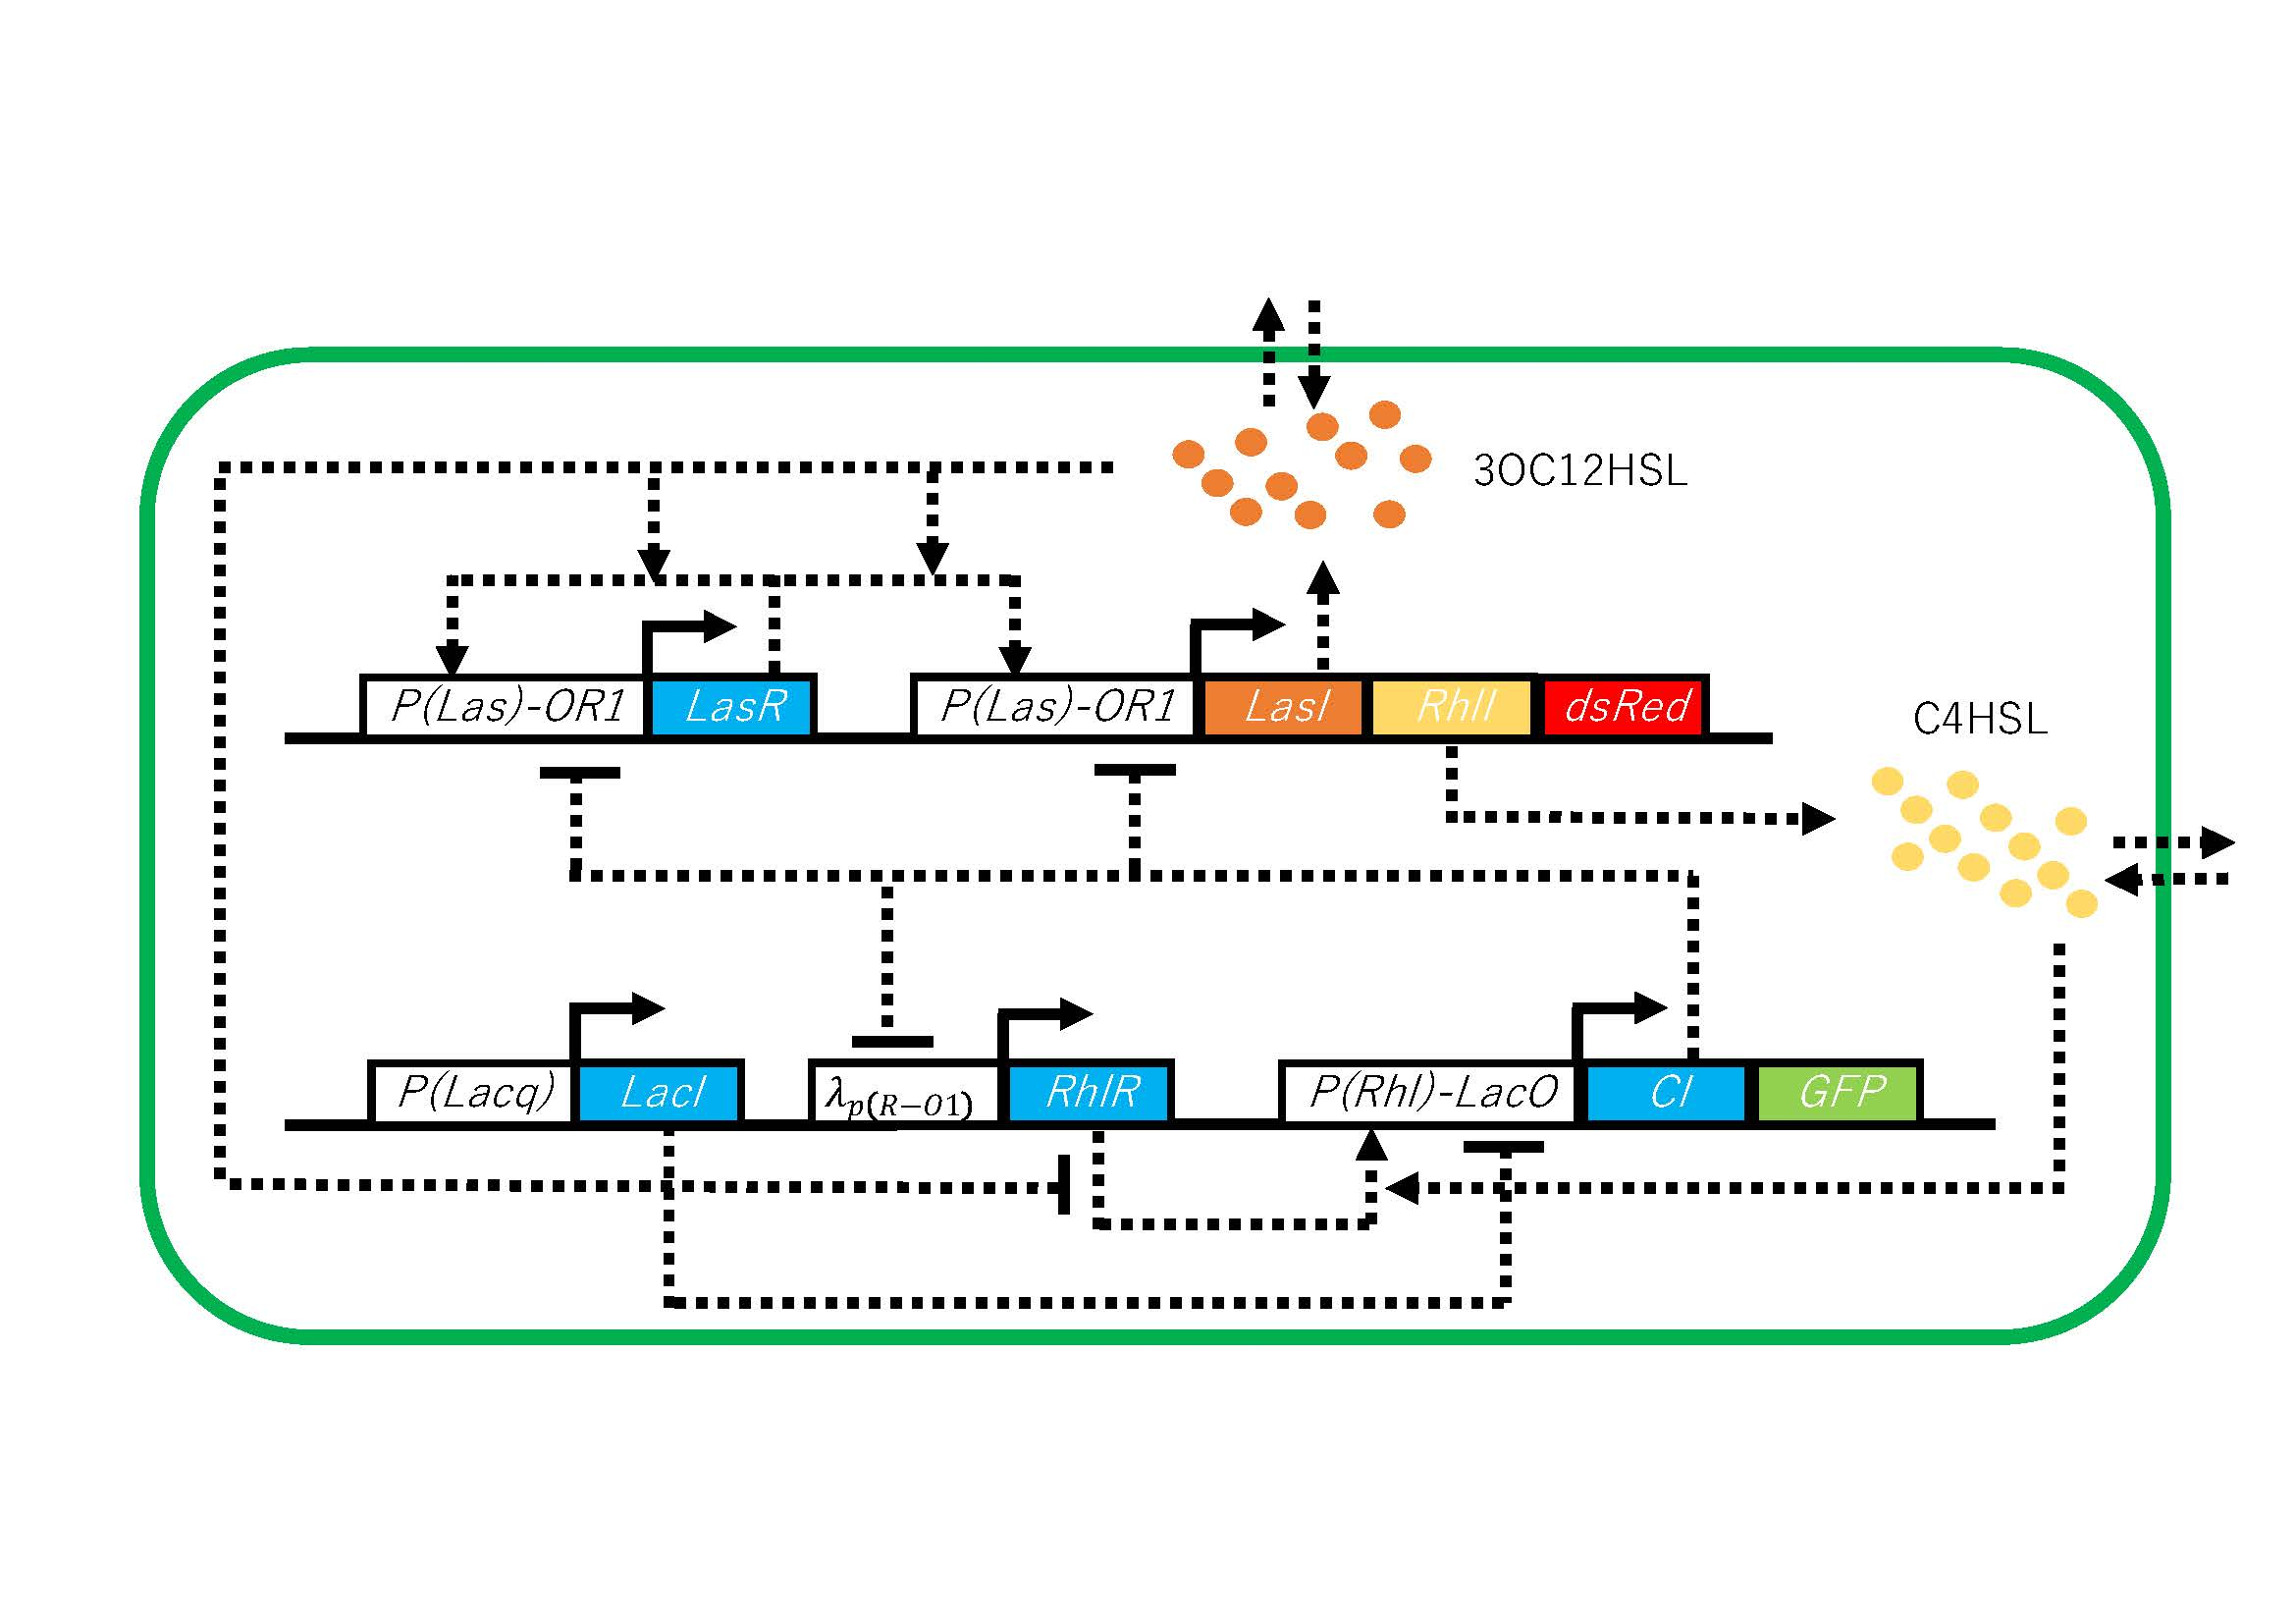

この遺伝子回路は以下の反応拡散方程式でモデル化される。（複雑なのでモデルの構造を完全に理解する必要はない。）

$\frac{\partial U}{\partial t}= \alpha_u I_u - \gamma_u U + D_u\nabla^2U $

$\frac{\partial V}{\partial t}= \alpha_v I_v - \gamma_v V + D_v\nabla^2V$

$\frac{\partial I_u}{\partial t}= \alpha_{iu} \frac{1+ f_1\left(\frac{X_1}{K_{d1}}\right)^{\theta_1}}{1+ \left(\frac{X_1}{K_{d1}}\right)^{\theta_1}} \frac{1+ f_2^{-1}\left(\frac{C}{K_{d2}}\right)^{\theta_2}}{1+ \left(\frac{C}{K_{d2}}\right)^{\theta_2}} - \gamma_{iu}I_u $

$\frac{\partial I_v}{\partial t}= \alpha_{iv} \frac{1+ f_1\left(\frac{X_1}{K_{d1}}\right)^{\theta_1}}{1+ \left(\frac{X_1}{K_{d1}}\right)^{\theta_1}} \frac{1+ f_2^{-1}\left(\frac{C}{K_{d2}}\right)^{\theta_2}}{1+ \left(\frac{C}{K_{d2}}\right)^{\theta_2}} - \gamma_{iv}I_v $

$\frac{\partial C}{\partial t}= \alpha_c \frac{1+ f_3\left(\frac{X_2}{K_{d3}}\right)^{\theta_3}}{1+ \left(\frac{X_2}{K_{d3}}\right)^{\theta_3}} \frac{1+ f_4^{-1}\left(\frac{L}{K_{d4}}\right)^{\theta_4}}{1+ \left(\frac{L}{K_{d4}}\right)^{\theta_4}} - \gamma_{c}C $

$U$：シグナル分子3OC12HSLの濃度

$V$：シグナル分子C4HSLの濃度

$I_u$：タンパク質LasIの濃度

$I_v$：RhlIの濃度

$C$：タンパク質CIの濃度

$X_1$ : LasR-3OC12HSL複合体の濃度

$X_2$ : RhlR-C4HSL複合体の濃度

$L$ : 未結合のLacIの濃度

$\nabla^2=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}$

ヒル関数：遺伝子発現制御をモデル化する際によく用いられる関数。促進型と抑制型がある。

\\
タンパク質CIの濃度の時間と空間的な変化をシミュレーションする。

（グラフの横軸と縦軸は空間的な位置を表し、色は分子濃度を表す。）

\\
出典：D. Karig et al., Stochastic Turing patterns in a synthetic bacterial population, *PNAS*, 115(26), 6572–6577. https://doi.org/10.1073/pnas.1720770115


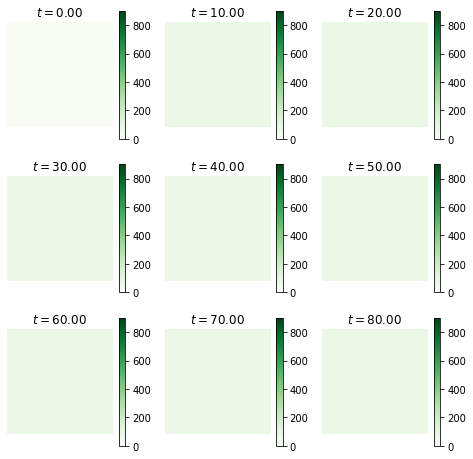

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# まずはパラメタを設定する
#@title Parameters { run: "auto", vertical-output: true, form-width: "50%", display-mode: "both" }

# 拡散係数
Du = 4 # @param {type:"slider", min:0, max:10, step:0.5} 
Dv = 18 #@param {type:"slider", min:0, max:50, step:1}
# シグナル分子3OC12HSLの生成率
alphau = 30  #@param {type:"slider", min:0, max:50, step:1}
# シグナル分子3OC12HSLの崩壊率
gammau = 1 #@param {type:"slider", min:0, max:10, step:0.1}
# 基準: Du=0.5, Dv=50, alphau=30, gammau=1

# 他のパラメタは固定する
alphav = 30
alphaiu = 10    
alphaiv = 0.3
alphac = 10
K1 = 1000      
K2 = 10
K3 = 100000
K4 = 100
K5 = 150
K6 = 0.001     
K7 = 1000      
gammav = 1
gammaiu = 1
gammaiv = 1
gammac = 1
n1 = 1   
n2 = 2
n3 = 1
n4 = 4
n5 = 1
n6 = 2
f1 = 1000    
f2 = 100000
f3 = 1000
f4 = 1000
f5 = 100000
f6 = 100000
lambdal = 150     
lambdau = 1       
lambdav = 1000
I = 1 * 10**(-6)   

# 時間幅と空間幅の設定
size = 64  # size of space
dx = 1 
T = 90  # total time
dt = .004  # time step
n = int(T / dt)  # number of iterations
t=np.arange(n)*dt

# 初期条件の設定（各分子濃度は空間的にランダムに分布）
U = np.random.normal(1.0, 0.05, (size, size))
V = np.random.normal(1.0, 0.05, (size, size))
A = np.random.normal(1.0, 0.05, (size, size))
B = np.random.normal(1.0, 0.05, (size, size))
C = np.random.normal(1.0, 0.05, (size, size))

# 拡散（空間的な二階微分）の計算を定義
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright - 4 * Zcenter) / dx**2
            
# シミュレーション結果の図の出力設定
def show_patterns(A, ax=None):
    show = ax.imshow(A.real, cmap=plt.cm.Greens,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1], vmin=0, vmax=900)
    ax.set_axis_off()
    cb = fig.colorbar(show, ax=ax)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
ims = []
step_plot = n // 9

# ここから反応拡散方程式の計算
for i in range(n):
    # 空間的な二階微分の計算
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # 境界を除いた箇所の更新
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    Ac = A[1:-1, 1:-1]
    Bc = B[1:-1, 1:-1]
    Cc = C[1:-1, 1:-1]
   
    # 上記の反応拡散方程式を離散化したもの（有限差分法）
    # 「有限要素法」もあるので，興味のある人は調べてみてください．
    U[1:-1, 1:-1], V[1:-1, 1:-1], A[1:-1, 1:-1], B[1:-1, 1:-1], C[1:-1, 1:-1] = \
        Uc + dt * (Du * deltaU + alphau * Ac - gammau * Uc),\
        Vc + dt * (Dv * deltaV + alphav * Bc - gammav * Vc),\
        Ac + dt * (alphaiu * ( (1 + f1*(lambdau * Ac * Uc/K1)**n1)/(1 + (lambdau * Ac * Uc/K1)**n1) ) * ( (1 + (1/f2)*(Cc/K2)**n2)/(1 + (Cc/K2)**n2) ) - gammaiu*Ac ),\
        Bc + dt * (alphaiv * ( (1 + f1*(lambdau * Ac * Uc/K1)**n1)/(1 + (lambdau * Ac * Uc/K1)**n1) ) * ( (1 + (1/f2)*(Cc/K2)**n2)/(1 + (Cc/K2)**n2) ) - gammaiv*Bc ),\
        Cc + dt * (alphac * ( (1 + f3*((lambdav * ( (1 + (1/f6)*(Cc/K7)**n6)/(1 + (Cc/K7)**n6)) * Vc)/(1 + Uc/K5)/K3)**n3)/(1 + ((lambdav * ( (1 + (1/f6)*(Cc/K7)**n6)/(1 + (Cc/K7)**n6)) * Vc)/(1 + Uc/K5)/K3)**n3) ) * ( (1 + (1/f4)*(lambdal * ( (1 + (1/f5)*(I/K6)**n5)/(1 + (I/K6)**n5))/K4)**n4)/(1 + (lambdal * ( (1 + (1/f5)*(I/K6)**n5)/(1 + (I/K6)**n5))/K4)**n4) ) - gammac*Cc )
       
    # 境界条件の設定（ノイマン境界条件）
    for Z in (U, V, A, B, C):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # シミュレーション結果の図の出力
    if i % step_plot == 0 and i < 9 * step_plot:
        ax = axes.flat[i // step_plot]
        show_patterns(C, ax=ax)
        ax.set_title(f'$t={i * dt:.2f}$')
    C_ = C.copy()
    ims.append(C_)
  


## 5.2 FitzHugh-Nagumo model（フィッツフュー・南雲モデル）

神経細胞などの電気的興奮性細胞の活動電位を表現したモデル

$\frac{\partial u}{\partial t}=u-\frac{u^3}{3}-v + I +D_u\nabla^2u$

$\frac{\partial v}{\partial t}=u-bv - a +D_v\nabla^2v$

$u$ : 膜電位

$v$ : 不活性化を表す変数

$I$ : 外部刺激電流


\\
パラメタを変えると、様々な現象を観察できることが知られている。

（周期振動やチューリング模様、ラビリンス模様など）

\\
膜電位$u$の時間と空間的な変化をシミュレーションする。

（グラフの横軸と縦軸は空間的な位置を表し、色は活動電位を表す。）

\\
出典：

B. Ambrosio, J. Françoise, Propagation of bursting oscillations, *PTMSFB*, 2009, 367(1908), 4863–4875. https://doi.org/10.1098/rsta.2009.0143

J. Nagumo et al., An Active Pulse Transmission Line Simulating Nerve Axon, *Proc. IRE*, 1962, 50(10), 2061–2070. https://ieeexplore.ieee.org/document/4066548

R. FitzHugh, Mathematical models of threshold phenomena in the nerve membrane, *Bull. Math. Biol.*, 1955, 17(4), 257–278. https://doi.org/10.1007/BF02477753

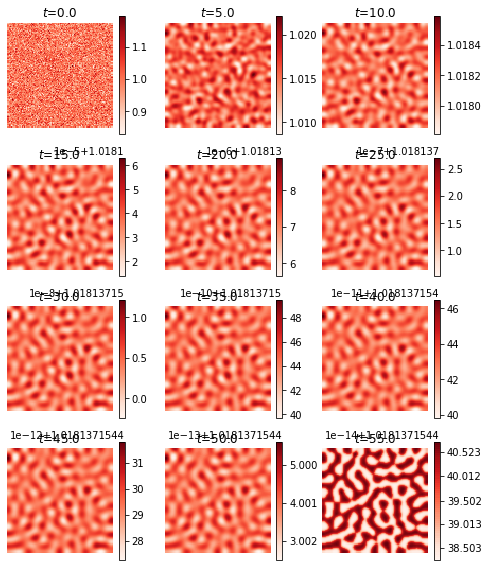

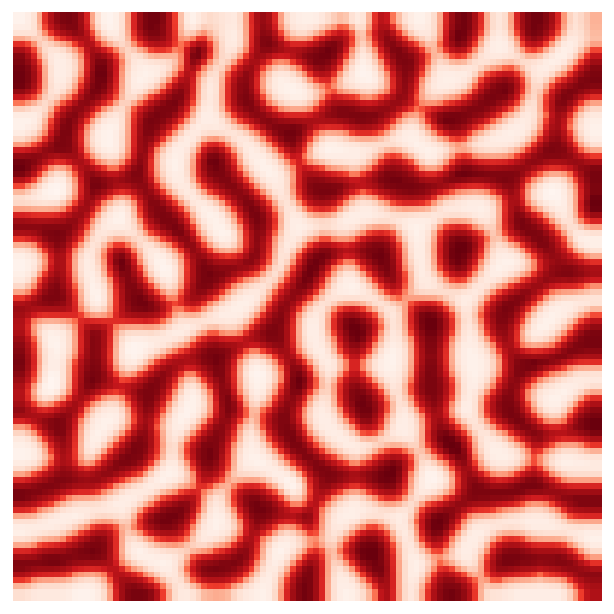

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML
#matplotlib inline

# まずはパラメタを設定する
#@title Parameters { run: "auto", vertical-output: true, form-width: "50%", display-mode: "both" }

I = -0.03
a = 0 
b = 1.6
DN = 3.0e-4
DP = 0.0035
tau = 1
# 振動: I=-0.01, a=0, b=0.5, DN=3.0e-4, DP=3.0e-3, tau=1 

size = 100  
dx = 2./size 
T = 60
dt = .02  # time step
n = int(T / dt)  # number of iterations
t=np.arange(n)*dt

# 初期条件（中心部に電位が分布している場合）
N = np.random.normal(1.0, 0.05, (size, size))

N[size//2 - 2:size//2 + 2,size//2 - 2:size//2 + 2] = np.random.normal(1.0, 0.05, (4, 4))
P = np.random.normal(1.0, 0.05, (size, size))

P[size//2 - 2:size//2 + 2,size//2 - 2:size//2 + 2] = np.random.normal(1.0, 0.05, (4, 4))


# 拡散（空間的な二階微分）の計算を定義
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright - 4 * Zcenter) / dx**2

# シミュレーション結果の図の出力設定
fig, axes = plt.subplots(4, 3, figsize=(8, 10))
ims = []
step_plot = n // 12

def show_patterns(U, ax=None):
    show = ax.imshow(U, cmap=plt.cm.Reds,
              interpolation='nearest',
              extent=[-1, 1, -1, 1])
    ax.set_axis_off()
    fig.colorbar(show, ax=ax)
            
# ここから反応拡散方程式の計算
for i in range(n):
    # 空間的な二階微分の計算
    deltaN = laplacian(N)
    deltaP = laplacian(P)
    
    # 境界を除いた箇所の更新
    Nc = N[1:-1, 1:-1]
    Pc = P[1:-1, 1:-1]
   
    # 上記の反応拡散方程式を離散化したもの（有限差分法）
    N[1:-1, 1:-1], P[1:-1, 1:-1] = \
        Nc + dt * (DN * deltaN + Nc - (Nc**3)/3 - Pc + I),\
        Pc + dt * (DP * deltaP + Nc - b*Pc - a)/tau

    # 境界条件の設定（ノイマン境界条件）
    for Z in (N, P):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # シミュレーション結果の図の出力
    if i % step_plot == 0 and i < 12*step_plot:
        ax = axes.flat[i // step_plot]
        show_patterns(N, ax=ax)
        ax.set_title('$t$='+str(t[i])+'')
    N_=N.copy()
    ims.append(N_)

fig, ax = plt.subplots(dpi=130, figsize=(6, 6))
ax.axis("off")
im = ax.imshow(ims[-1],cmap=plt.cm.Reds,interpolation='nearest')


In [ ]:
# アニメーションを表示する
def update(num):
    im.set_array(ims[50*num])
    im.set_clim(ims[50*num].min(),ims[50*num].max())
    ax.set_title("t="+str(np.round(t[50*num],2))+"")
    return fig,
    
ani = animation.FuncAnimation(fig, update, 60,interval=60)
rc('animation', html='jshtml')
ani


本教材は、**分子ロボティクス夏の学校2022ソフトウェア講習6**の内容をもとに作成しました。